partd) 

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/HW5/airline-passengers.csv')
data

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [89]:
data['Month'] = pd.to_datetime(data['Month'])

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [91]:
data.set_index('Month', inplace=True)

In [92]:
data

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


Fix the random number seed to 0 in numpy for reproducibility. 

In [93]:

np.random.seed(0)

Convert the integer values in the data to ﬂoating point values, which are more suitable for modeling with a neural network.

In [94]:
data['Passengers'] = data['Passengers'].astype(float)

In [95]:
data['Passengers']

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Name: Passengers, Length: 144, dtype: float64

 Normalize the data to range (0,1) since LSTMs are sensitive to the scale of the input data, speciﬁcally when the sigmoid or tanh activation functions are used. You can use the MinMaxScaler function in sklearn. 
 

In [96]:
#data_Scaling
data['Passengers']
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(data)

In [97]:
data

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984556],
       [0.08494208],
       [0.08494208],
       [0.06177606],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123552],
       [0.04247104],
       [0.07142857],
       [0.05984556],
       [0.04054054],
       [0.08687259],
       [0.12741313],
       [0.12741313],
       [0.1042471 ],
       [0.05598456],
       [0.01930502],
       [0.06949807],
       [0.07915058],
       [0.08880309],
       [0.14285714],
       [0.11389961],
       [0.13127413],
       [0.14285714],
       [0.18339768],
       [0.18339768],
       [0.15444015],
       [0.11196911],
       [0.08108108],
       [0.11969112],
       [0.12934363],
       [0.14671815],
       [0.17181467],
       [0.14864865],
       [0.15250965],
       [0.22007722],
       [0.24324324],
       [0.26640927],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

Split the ﬁrst 67% of the data as training data and the remaining 33% as testing data.

In [98]:
#Creating train and test partition
train = int(len(data)*0.67)
test = len(data)-train

train

test

train_data,test_data=data[0:train,:],data[train:len(data),:1]

Obtain the two-column input-output dataset to be used in LSTM, where the ﬁrst column is the input (number of passengers in the current month) for each instance (i.e., each row), and the second column is the output (number of passengers next month). In this dataset, the values in the ﬁrst column will be the same as the values in the second column of previous row.

In [99]:
# converting an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

Reshape the input data to be in the [samples, time steps, features] format, which LSTM network expects. The time step will be 1 with this dataset since each monthly sample represents a unit time step. You can use the
1
reshape function in numpy with (Xtrain.shape[0], 1, Xtrain.shape[1]) as the new size, where Xtrain is the training input data. Apply the same reshaping to the test data Xtest. 

In [100]:
# reshape into X=t and Y=t+1
time_step = 3
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_train

array([[0.01544402, 0.02702703, 0.05405405],
       [0.02702703, 0.05405405, 0.04826255],
       [0.05405405, 0.04826255, 0.03281853],
       [0.04826255, 0.03281853, 0.05984556],
       [0.03281853, 0.05984556, 0.08494208],
       [0.05984556, 0.08494208, 0.08494208],
       [0.08494208, 0.08494208, 0.06177606],
       [0.08494208, 0.06177606, 0.02895753],
       [0.06177606, 0.02895753, 0.        ],
       [0.02895753, 0.        , 0.02702703],
       [0.        , 0.02702703, 0.02123552],
       [0.02702703, 0.02123552, 0.04247104],
       [0.02123552, 0.04247104, 0.07142857],
       [0.04247104, 0.07142857, 0.05984556],
       [0.07142857, 0.05984556, 0.04054054],
       [0.05984556, 0.04054054, 0.08687259],
       [0.04054054, 0.08687259, 0.12741313],
       [0.08687259, 0.12741313, 0.12741313],
       [0.12741313, 0.12741313, 0.1042471 ],
       [0.12741313, 0.1042471 , 0.05598456],
       [0.1042471 , 0.05598456, 0.01930502],
       [0.05598456, 0.01930502, 0.06949807],
       [0.

In [101]:
y_train

array([0.04826255, 0.03281853, 0.05984556, 0.08494208, 0.08494208,
       0.06177606, 0.02895753, 0.        , 0.02702703, 0.02123552,
       0.04247104, 0.07142857, 0.05984556, 0.04054054, 0.08687259,
       0.12741313, 0.12741313, 0.1042471 , 0.05598456, 0.01930502,
       0.06949807, 0.07915058, 0.08880309, 0.14285714, 0.11389961,
       0.13127413, 0.14285714, 0.18339768, 0.18339768, 0.15444015,
       0.11196911, 0.08108108, 0.11969112, 0.12934363, 0.14671815,
       0.17181467, 0.14864865, 0.15250965, 0.22007722, 0.24324324,
       0.26640927, 0.2027027 , 0.16795367, 0.13127413, 0.17374517,
       0.17760618, 0.17760618, 0.25482625, 0.25289575, 0.24131274,
       0.26833977, 0.30888031, 0.32432432, 0.25675676, 0.20656371,
       0.14671815, 0.18725869, 0.19305019, 0.16216216, 0.25289575,
       0.23745174, 0.25096525, 0.30888031, 0.38223938, 0.36486486,
       0.2992278 , 0.24131274, 0.19111969, 0.24131274, 0.26640927,
       0.24903475, 0.31467181, 0.31853282, 0.32046332, 0.40733

In [102]:
X_train.shape, y_train.shape


((92, 3), (92,))

In [103]:
# reshape input to be [sample, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0], 3, 1)
X_test = X_test.reshape(X_test.shape[0], 3, 1 )

X_train.shape

(92, 3, 1)

In [104]:
y_train.shape

(92,)

Build the LSTM network with a hidden layer of 4 neurons, and an output layer with a single neuron. Use sigmoid activation function in the hidden layer, 100 epochs, batch size of 1, “adam” optimizer, and mean-squarederror loss

In [105]:
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.compat.v1.keras.layers import Dense,CuDNNLSTM, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math 


model=Sequential()
#model.add(LSTM(4, input_dim=1))
model.add(LSTM(50,return_sequences=True,input_shape=(3,1)))#INPUT
model.add(LSTM(4))#HIDDEN layer
model.add(Dense(1))#outputlayer
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=1,verbose=1)

Epoch 1/100
92/92 [==============================] - 1s 11ms/step - loss: 0.0262 - val_loss: 0.0887
Epoch 2/100
92/92 [==============================] - 0s 5ms/step - loss: 0.0091 - val_loss: 0.0528
Epoch 3/100
92/92 [==============================] - 0s 5ms/step - loss: 0.0067 - val_loss: 0.0376
Epoch 4/100
92/92 [==============================] - 0s 5ms/step - loss: 0.0055 - val_loss: 0.0231
Epoch 5/100
92/92 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 0.0318
Epoch 6/100
92/92 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 0.0270
Epoch 7/100
92/92 [==============================] - 0s 5ms/step - loss: 0.0053 - val_loss: 0.0223
Epoch 8/100
92/92 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0297
Epoch 9/100
92/92 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0288
Epoch 10/100
92/92 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0323
Epoch 11

In [106]:
X_train.shape, y_train.shape

((92, 3, 1), (92,))

 Predict the next month’s number of passengers and invert the predictions using the “inverse-transform” attribute of MinMaxScaler to go back to the original unit (thousands of passengers per month). 

In [107]:
#Model Prediction
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)



In [108]:
#Transforming data back to original form
train_predict=scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict=scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])



Calculate and print the root-mean-squared-error (RMSE) in training and test data. 

In [109]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.24 RMSE
Test Score: 70.43 RMSE


 Finally, align and plot the actual and predicted values for the entire dataset including training and testing

In [110]:
train_predict

array([[125.00249 ],
       [125.592606],
       [120.58578 ],
       [129.1545  ],
       [140.26657 ],
       [143.00533 ],
       [134.70076 ],
       [121.03407 ],
       [107.844986],
       [113.365906],
       [112.58195 ],
       [120.79976 ],
       [133.12253 ],
       [131.7248  ],
       [124.79304 ],
       [140.73862 ],
       [159.79762 ],
       [163.4574  ],
       [154.67247 ],
       [134.2099  ],
       [117.65212 ],
       [131.91675 ],
       [138.03223 ],
       [144.63518 ],
       [168.44864 ],
       [157.78487 ],
       [166.82954 ],
       [171.44919 ],
       [191.33804 ],
       [191.22432 ],
       [178.20987 ],
       [159.22174 ],
       [145.17664 ],
       [159.2921  ],
       [163.9009  ],
       [173.39696 ],
       [185.69968 ],
       [174.9154  ],
       [177.9007  ],
       [210.43292 ],
       [220.59393 ],
       [234.30553 ],
       [196.20888 ],
       [185.51393 ],
       [168.12779 ],
       [187.93681 ],
       [188.26501 ],
       [189.5

In [111]:
test_predict

array([[366.95956],
       [304.10828],
       [337.62347],
       [429.31818],
       [414.73688],
       [381.46524],
       [293.54102],
       [301.4465 ],
       [275.57883],
       [343.7482 ],
       [314.0064 ],
       [284.26047],
       [370.7587 ],
       [300.5414 ],
       [352.1604 ],
       [440.5685 ],
       [439.9999 ],
       [405.87177],
       [234.02684],
       [345.51047],
       [270.10223],
       [344.9753 ],
       [343.46558],
       [298.32224],
       [422.1894 ],
       [321.72754],
       [406.1291 ],
       [451.4183 ],
       [505.15753],
       [404.1206 ],
       [274.63858],
       [388.0026 ],
       [321.83145],
       [421.7572 ],
       [365.83807],
       [324.29153],
       [416.9068 ],
       [432.19073],
       [396.27478],
       [517.49054],
       [546.99963],
       [360.83884],
       [354.55975],
       [457.83783]], dtype=float32)

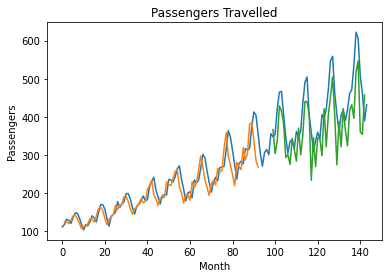

In [117]:
look_back = 1
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict#
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*6)+1:len(data)-1, :] = test_predict#
# plot baseline and predictions
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.title("Passengers Travelled")
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()                